In [4]:
## Packages
'''Import all the necessary packages and modules'''
import pandas as pd
from pycroscopy.io.translators.df_utils.dm_utils import read_dm3
import numpy as np # package for playing with matrices
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
# from sklearn.decomposition import PCA
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter
import glob
# from sklearn import preprocessing
%load_ext autoreload
%autoreload 2

In [5]:
## Data Directory GUI
'''Getting data directory so data can easily be imported '''
def get_dir(new=True):
    '''Opens a window to select directory if new==False gets current directory
    Returns the directory as a string
    '''
    if new==True:
        root = Tk() # Tk() is a function in tkinter that opens a window
        root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
        root.withdraw() # closes the tkinter window since it's unnecessary
        oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
        os.chdir(root.directory) # sets new directory
        newcwd = os.getcwd() # saves new directory name as newcwd
        return root.directory
    if new==False:
        cd=os.getcwd()
        return cd
folder=get_dir()

In [6]:
## Load Data use for .csv data
''' Makes a list of all the files with the extension use * to use for importing'''

path = folder + '/'+'*.dm3' # Change '' as needed
file_list=sorted(glob.glob(path))
list(enumerate(file_list)) # list all files and their corresponding index in the list file_list

[(0, 'Z:/Carrier Paper/OnOff Images\\0.4V.dm3'),
 (1, 'Z:/Carrier Paper/OnOff Images\\RF_off_after_0.3V.dm3')]

In [7]:
def load_dm3(filename,get_meta=False, stack=False):
    '''Loads a single dm3 into a numpy array. If get_meta=True gets all corresponding metadata aswell
    Returns an numpy array of the dm3
    '''
    if (stack==True) | (np.array(filename).size!=1):
        
        image_size= read_dm3(filename[0])[0].shape
        num_images=len(filename)
        stack_size=(image_size[0],image_size[1], len(filename)) # set size of data_stack 
        data_stack=np.zeros(stack_size) # Preallocate the data_stack
        meta_size=[]
        '''Determine the size of the meta data'''
        for n in range(len(filename)): 
            meta_size.append(len(list(read_dm3(filename[n])[1].items())))
        meta_dim1=np.max(meta_size)
        meta_stack=np.zeros((meta_dim1,2,len(filename)),dtype=np.object_)
        '''Parse the image intensities from the meta data and load into data_stack and meta_stack'''
        for n in range(len(filename)):
            data_stack[:,:,n]=read_dm3(filename[n])[0]
        if get_meta==True:
            for n in range(len(filename)):
                string_stack=list(read_dm3(filename[n])[1].items())
                if len(string_stack)<meta_dim1:
                    diff=meta_dim1-len(string_stack)
                    for x in range(diff):
                        string_stack.append(([],[]))
                meta_stack[:,:,n]=string_stack # Use meta_stack[:,:,#] to look at the meta_data for file #
            return data_stack, meta_stack
            
        return data_stack
        
    image_size= read_dm3(filename)[0].shape
    image=np.zeros(image_size)
    meta=np.zeros((len(list(read_dm3(filename)[1].items())),2),dtype=np.object_)
    image[:,:]=read_dm3(filename)[0]
    meta[:,:]=list(read_dm3(filename)[1].items())
    if get_meta==True:
        return image, meta
    return image

In [577]:
def shift_image(im,shift,delete=True,fill=0):
    from scipy.ndimage import fourier_shift
    """Shifts image based on scipy.ndimage shift vector.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    shift : sequence
        The size of the box used for filtering.
        If a float, `shift` is the same for all axes. If a sequence, `shift`
        has to contain one value for each axis.

    Returns
    -------
    fourier_shift : ndarray
        The shifted input.

    """
    
    rank=im.ndim
    if hasattr(shift, '__iter__'):
        n_shift = list(shift)
    else:
        n_shift = [shift] * rank  
    fft_im=fourier_shift(np.fft.fftn(im),n_shift)
    shifted_im=np.fft.ifftn(fft_im)
#     return shifted_im,n_shift
    if delete ==True:
        ylim=int(n_shift[0])
        xlim=int(n_shift[1])
        if ylim>=0:
            shifted_im[0:ylim,:]=fill
        if ylim<0:
            shifted_im[ylim:,:]=fill
        if xlim>=0:
            shifted_im[:,0:xlim]=fill
        if xlim<0:
            shifted_im[:,xlim:]=fill
        
    return np.array(shifted_im)

def to_8bit(image):
    im=image.copy()
    im=(im-np.min(im)).real
    im=(im/np.max(im))*255

    return im.astype(int)
def to_binary(image):
    im=image.copy()
    mean=np.mean(im)
    im[im<=mean]=0
    im[im>mean]=1
    return im.astype(int)
def thresh(image,threshtype='local', make_binary=True, simple=False):
    im=image.copy()
    if simple==True:
        im[im<0]=0
        return im

    if threshtype=='global':
        from skimage.filters import threshold_otsu
        try:
            thresh = threshold_otsu(im) 
        except ValueError:
            thresh=0
        binary= im>thresh
        
        if make_binary==False:
            return binary
        return binary.astype(int)
            
    if threshtype=='local':
        from skimage.filters import threshold_sauvola
        thresh = threshold_sauvola(im)

    binary = im< thresh
    if make_binary==False:
        return binary
    return binary.astype(int)
def gaussian_filter(image,sig=3):
    from skimage.filters import gaussian
    im=image.copy()
    g = gaussian(im, sigma=sig, preserve_range=True)
    return g
def binarize(image,sig=3,threshtype='local'):
    im=image.copy()
    t=thresh(im,threshtype=threshtype)
    filt=gaussian_filter(t,sig)
    binary=thresh(filt,threshtype='global').astype(int)
    return binary.astype(int)

def rigid_registration(to_be_registered,reference,pixel_resolution,get_shift=False):
    from skimage.feature import register_translation
    to_be_registered_bin=binarize(to_be_registered)
    reference_bin=binarize(reference)
    upsample_factor=1/pixel_resolution
    shift, error, diffphase = register_translation(reference_bin,to_be_registered_bin, upsample_factor)
    shifted_image=shift_image(to_be_registered,shift)
    if get_shift==True:
        return shifted_image.real, shift
    return shifted_image.real



In [566]:
import numpy as np
from warnings import warn
def outliers(image,quart=5, num_stdev=2, get_cutoff=False, dist='Normal',index=False, diff=False):
    """Check if value is an outlier based on standard deviations
    quart and num_stdev determine the qualifiers for the outlier (mean +- 1.5*(inner quartile) and mean +- num_stdev *std)
    get_cutoff=True gets the value of the cutoff as determined by num_stdev and quart
    Use dist='Normal' for normal distributions and dist=any other string if not normal dist
    returns boolean array the same size as image where each element is True if an outlier

    """

    if dist=='Normal':
        """Check if value is an outlier based on normal distributions"""
        m=np.mean(image)
        std=np.std(image)
        cutoff=num_stdev*std
        lower, upper = m-cutoff, m+cutoff
        outs =np.logical_or(image<=lower,image>=upper)
        if index==False:
            if get_cutoff==True:
                return outs, (lower, upper)
            return outs
        if index==True:
            if get_cutoff==True:
                return outs, np.argwhere(outs),(lower, upper)
            return outs, np.argwhere(outs)

    else:
        """Check if value is an outlier based on percentiles"""
        uquart=100-quart
        q25, q75 = np.percentile(image, quart), np.percentile(image, uquart)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outs =np.logical_or(image<=lower,image>=upper)
        if index==False:
            if get_cutoff==True:
                return outs, (lower, upper)
            return outs
        if index==True:
            if get_cutoff==True:
                return outs, np.argwhere(outs),(lower, upper)
            return outs, np.argwhere(outs)

def local_mean(matrix, y_axis, x_axis, NN=1):
    '''Gets the local mean around a specific index in the matrix
        with NN 1=3x3 -center point = 8 points NN; 2=5x5 -center pt = 24 points!
        Now works with any size by folding around at edges
        Returns the local mean for the specified x and y
        '''
    if (NN+2)**2>=matrix.size:
        raise ValueError("NN is larger than input matrix")
    local_data=[]
    numb=[]
    nsize=matrix.shape[0]-1
    msize=matrix.shape[1]-1
    for n in range(-NN, NN+1,1) :
        for m in range(-NN, NN+1,1):
            if m==0 and n==0:
                continue

            if  y_axis+n>nsize and   x_axis+m>msize:  #Cycles around far corner back to 0,0 for arbitrary size
                k = (y_axis+n)
                k = k % nsize-1
                l = (x_axis+m)
                l = l % msize-1
                local_data.append(matrix[k, l])
                numb.append([k, l])
                continue

            if y_axis+n>nsize:
                k = y_axis+n
                k = k% nsize-1
                local_data.append(matrix[k, x_axis + m])
                numb.append([k,x_axis + m])
                continue
            if   x_axis+m>msize:
                l = (x_axis+m)
                l = l % msize-1
                local_data.append(matrix[y_axis +n, l])
                numb.append([y_axis, l])
                continue

            local_data.append(matrix[y_axis+n,x_axis+m])
            numb.append([y_axis+n,x_axis+m])

    loc_mean=np.mean(local_data)

    return loc_mean

def diff_outliers(image,quart=5,num_stdev=2,dist='Normal',axis='both',index=False):
    ''' Returns an array of shape image with the outliers (based on X and Y derivatives aka slopes)
    of the image of type True. Outliers are designated by outliers function.
    axis determines the direction of derivate and selecting both combines both derivatives
    If index=True, the function returns the index of where the outliers are in the image.
    '''
    if image.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    if image.size<25:
        warn('Outliers may not be found since Matrix dimensions are small')
    mat=image
    if axis=='both':
        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)
        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')

        diffy= np.logical_and(diffy1,diffy1a)

        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)
        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')
        diffx= np.logical_and(diffx1,diffx1a)


        diff=np.logical_or(diffx,diffy)
        if index==True:
            return np.argwhere(diff)
        return diff

    if axis==0:

        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)

        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')

        diffy= np.logical_and(diffy1,diffy1a)
        if index==True:
            return np.argwhere(diffy)
        return diffy
    if axis==1:

        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)

        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')

        diffx= np.logical_and(diffx1,diffx1a)
        if index==True:
            return np.argwhere(diffx)
        return diffx

def remove_outliers(image,NN=1,quart=5,num_stdev=2, get_out=False, dist='Normal',axis='both', num_out=False, diff=True):
    '''Takes an image (numpy array) and replaces outliers (determined by outliers function)
    with the local means determined by the local mean function
    Returns the image with the outliers removed.
    If get_out=True it returns the values of the outliers from the image
    '''
    if diff==True:
        '''Removes outliers based on the slopes using the diff_outlier function
        Returns the original image with the difference outliers replaced by the local mean
        if num_out =True it returns number of outliers
        If get_out=True it returns the values of the outliers from the image

        '''
        outlier_index=diff_outliers(image, quart=quart,num_stdev=num_stdev, dist=dist,axis=axis, index=True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean
        if num_out==True:
            return outlier_index.shape[0]
        if get_out ==True:
            return outliers_removed, outliers_removed[outlier_index]

        return outliers_removed

    if dist=='Normal':
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed
    else:
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev, get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed

In [9]:
def coord_to_im(xyz,shape='square'):
    '''Return image from xyz coordinates as an nxm matrix'''
    z=xyz[:,2]
    if shape=='square':
        l=int(xyz.shape[0]**.5)
        image=z.reshape(l,l).T
        return image

    y,x=shape
    image=z.reshape(y,x)
        
    return image

def im_to_coord(image):
    '''Return image xyz coordinates as an X*Yx3 matrix'''
    n,m=image.shape
    yy,xx=np.meshgrid(np.arange(n),np.arange(m))
    x=xx.flatten()
    y=yy.flatten()
    z=image[y.astype(np.int),x.astype(np.int)]
    im_coordinates=np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]),axis=1)
    return im_coordinates
def make_odd(N):
    X=int(N)
    if X%2:
        return N
    Y=X+1
    return Y
def make_even(N):
    X=int(N)
    if X%2:
        Y=X+1
        return Y
    return N

In [571]:
im1=remove_outliers(load_dm3(file_list[0]),NN=2)
im2=remove_outliers(load_dm3(file_list[1]),NN=2)

In [578]:
im2_shifted=rigid_registration(im2,im1,.5)

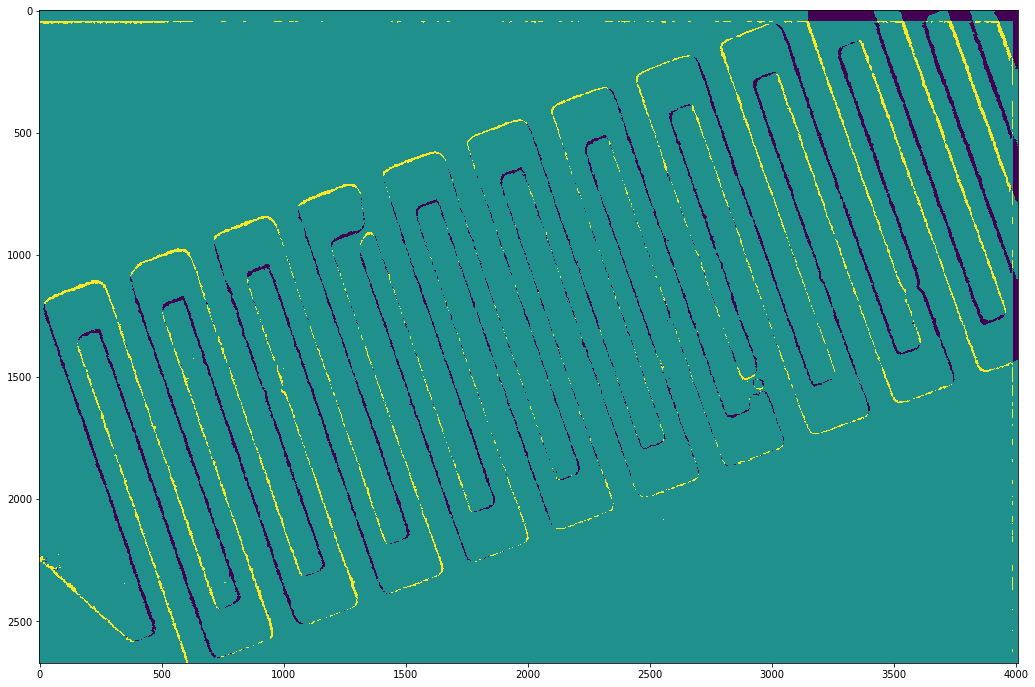

In [579]:
plt.figure(figsize=(18,12))
plt.imshow(binarize(im2_shifted)-binarize(im1))

In [580]:
def image_correlation(image1, image2):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    im1=im_to_coord(image1)
    im2=im_to_coord(image2)
    z1=im1[:,2]
    z2=im2[:,2]
    mu_z1 = z1.mean()
    mu_z2 = z2.mean()
    n = z1.shape[0]
    s_z1 = z1.std(0, ddof=n - 1)
    s_z2 = z2.std(0, ddof=n - 1)
    cov = np.dot(z1,
                 z2.T) - n * np.dot(mu_z1,
                                  mu_z2)
    return cov / np.dot(s_z1, s_z2)

## Did we do better?

In [581]:
print('Correlation before shift =',round(image_correlation(binarize(im1),binarize(im2)),2))
print('Correlation after shift =',round(image_correlation(binarize(im1),binarize(im2_shifted)),2))

Correlation before shift = 0.4
Correlation after shift = 0.89


In [447]:
def slope_from_points(pts):
    M=np.array(pts)
    if (M[0,0]-M[1,0])==0:
        return np.Inf
    m=(M[0,1]-M[1,1])/(M[0,0]-M[1,0])

    return m
def perp_slope_from_points(pts):
    m=slope_from_points(pts)
    if m==0:
        return np.Inf
    return -1/m

def get_line_params(pts):
    pts=np.array(pts)
    m=slope_from_points(pts)
    if m==np.Inf:
        return m, np.nan
    b=m*pts[0,0]-pts[0,1]
    return m,b
    
def get_line_width_coords(pts, width):
    '''Gets coordinates (x,y) coordinates for 4 positions based on width given
       pts is input as [(x1,y1),(x2,y2)]
       returns start, end 
       start = [bottom_start,top_start]
       bottom_start=(x,y)
       top_start=(x,y)
       similar for end
    '''
    pts=np.array(pts)
    m,b=get_line_params(pts)
    x1,x2=pts[0,0],pts[1,0]
    y1,y2=pts[0,1],pts[1,1]
    if x2<x1:
        xt=x2.copy()
        x2=x1.copy()
        x1=xt.copy()
        yt=y2.copy()
        y2=y1.copy()
        y1=yt.copy()
#     return x1,x2, y1,y2
    
    theta=np.arctan(m)
#     return np.cos(theta), np.sin(theta)
    if m<0:
            
        botx_start=np.rint(x1+np.sin(theta)*width/2)
        topx_start=np.rint(x1-np.sin(theta)*width/2)
        botx_end=np.rint(x2+np.sin(theta)*width/2)
        topx_end=np.rint(x2-np.sin(theta)*width/2)

        
        boty_start=np.rint(y1-np.cos(theta)*width/2)
        topy_start=np.rint(y1+np.cos(theta)*width/2)
        boty_end=np.rint(y2-np.cos(theta)*width/2)
        topy_end=np.rint(y2+np.cos(theta)*width/2)
        
        
    if m>0:

        botx_start=np.rint(x1+np.sin(theta)*width/2)
        topx_start=np.rint(x1-np.sin(theta)*width/2)
        botx_end=np.rint(x2+np.sin(theta)*width/2)
        topx_end=np.rint(x2-np.sin(theta)*width/2)
            
        
        boty_start=np.rint(y1-np.cos(theta)*width/2)
        topy_start=np.rint(y1+np.cos(theta)*width/2)
        boty_end=np.rint(y2-np.cos(theta)*width/2)
        topy_end=np.rint(y2+np.cos(theta)*width/2)
        
    if m==0:
        botx_start=np.rint(x1)
        topx_start=np.rint(x1)
        botx_end=np.rint(x2)
        topx_end=np.rint(x2)

        boty_start=np.rint(y1-width/2)
        topy_start=np.rint(y1+width/2)
        boty_end=np.rint(y2-width/2)
        topy_end=np.rint(y2+width/2)
              
    if m==np.inf:
        if y1>y2:
            boty_start=np.rint(y2)
            topy_start=np.rint(y2)
            boty_end=np.rint(y1)
            topy_end=np.rint(y1)
        if y1<y2:
            boty_start=np.rint(y1)
            topy_start=np.rint(y1)
            boty_end=np.rint(y2)
            topy_end=np.rint(y2)
            
        botx_start=np.rint(x1+width/2)
        topx_start=np.rint(x1-width/2)
        botx_end=np.rint(x2+width/2)
        topx_end=np.rint(x2-width/2)
#     x=np.array([botx_start,topx_start,topx_end,botx_end])
#     y=np.array([boty_start,topy_start,topy_end,boty_end])
#     return x,y
#     return m
    c1=(botx_start.astype(int),boty_start.astype(int))
    c2=(topx_start.astype(int),topy_start.astype(int))
    start=[c1,c2]
    start.sort(key=lambda x:x[1])
    c3=(botx_end.astype(int),boty_end.astype(int))
    c4=(topx_end.astype(int),topy_end.astype(int))
    end=[c3,c4]
    end.sort(key=lambda x:x[1])
    outlist=[start,end]
    outlist.sort(key=lambda x:x[0][0])
    return [outlist[0][0],outlist[0][1],outlist[1][1],outlist[1][0]]

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'r-',linewidth=4)
def draw_box(im,corners,binary=True):
    '''Draw a box on the image with the given corners
    corners like [(x1,y1),(x2,y2),(x3,y3),(x4,y4)]'''
    if binary==False:
        plt.imshow(im)
    else:
        plt.imshow(binarize(im))
    pts=np.asarray(corners)
    x=pts[:,0]
    y=pts[:,1]
    x=np.append(x,pts[0,0])
    y=np.append(y,pts[0,1])
    for i in np.arange(0,len(x)-1):
        connectpoints(x,y,i,i+1)
    return plt.gcf()
def im_linescan(im,pts,width,thresh_type=None, show=False, show_bin=False):
    from skimage.transform import rotate
    pts=np.asarray(pts)
    m,b=get_line_params(pts)
    theta=np.arctan(m)
    x1,x2=pts[0,0],pts[1,0]
    y1,y2=pts[0,1],pts[1,1]
    if x1<x2:
        centx=x1.astype(int)
        centy=y1.astype(int)
    if x1>x2:
        centx=x2.astype(int)
        centy=y2.astype(int)

    
    d=np.rint(((x1-x2)**2+(y1-y2)**2)**.5).astype(int)
    
    image=im.copy()
    if thresh_type=='binarize':
        image=binarize(image)
    if thresh_type=='loc_thresh':
        image=thresh(image)
    if thresh_type=='glob_thresh':
        image=thresh(image, thresh_type='global')
#     print(m)
    if (m!=0) & (m!=np.inf):
        image=rotate(image,theta*180/np.pi,center=(centx,centy),mode='constant',cval=np.nan, order=0,preserve_range=True)
        ymin=np.rint(centy-width/2).astype(int)
        ymax=np.rint(centy+width/2).astype(int)
        xmin=centx
        xmax=int(xmin+d)
        
        Y=image[ymin:ymax+1,xmin:xmax+1]
        if x1>x2:
            Y=np.nansum(Y,axis=0)[::-1]
            if show==True:
                pts=np.asarray(get_line_width_coords([[x1,y1],[x2,y2]],width))
                draw_box(im,pts, binary=show_bin)
        if x2>x1:
            Y=np.nansum(Y,axis=0)
            if show==True:
                pts=np.asarray(get_line_width_coords([[x1,y1],[x2,y2]],width))
                draw_box(im,pts, binary=show_bin)
        return Y

#         return ymin,ymax,xmin,xmax
#         return image
    elif m==0:
        ymin,ymax=(np.rint(y1-width/2)).astype(int),(np.rint(y1+width/2)).astype(int)
        if x1<x2:
            xmin,xmax=x1.astype(int),x2.astype(int)
        if x2<x1:
            xmin,xmax=x2.astype(int),x1.astype(int)
        Y=image[ymin:ymax+1,xmin:xmax+1]
        Y=np.nansum(Y,axis=0)
        if show==True:
            pts=np.asarray(get_line_width_coords([[x1,y1],[x2,y2]],width))
            draw_box(im,pts, binary=show_bin)
        return Y

    elif m==np.inf:
        xmin=np.rint(x1-width/2).astype(int)
        xmax=np.rint(x1+width/2).astype(int)
        if y1<y2:
            ymin,ymax=y2.astype(int),y1.astype(int)
        if y1<y2:
            ymin,ymax=y1.astype(int),y2.astype(int)
        Y=image[ymin:ymax+1,xmin:xmax+1]
        Y=np.nansum(Y,axis=1)
        if show==True:
            pts=np.asarray(get_line_width_coords([[x1,y1],[x2,y2]],width))
            draw_box(im,pts, binary=show_bin)
        return Y
            

In [687]:
def save_im(im, name, immin=0):
    import os
    cmap = plt.cm.gray
    norm = plt.Normalize(vmin=immin, vmax=im.max())
    fname = name
    save_im = cmap(norm(im))
    plt.imsave(fname, save_im, dpi=600)
    print('Saved to'+os.getcwd()+'\\'+fname)
    

In [689]:
save_im(im2,'Off_Full.png')

Saved toZ:\Carrier Paper\OnOff Images\Off_Full.png


In [691]:
save_im(On_crop,'On_cropped.png')
save_im(Off_crop,'Off_cropped.png')

Saved toZ:\Carrier Paper\OnOff Images\On_cropped.png
Saved toZ:\Carrier Paper\OnOff Images\Off_cropped.png


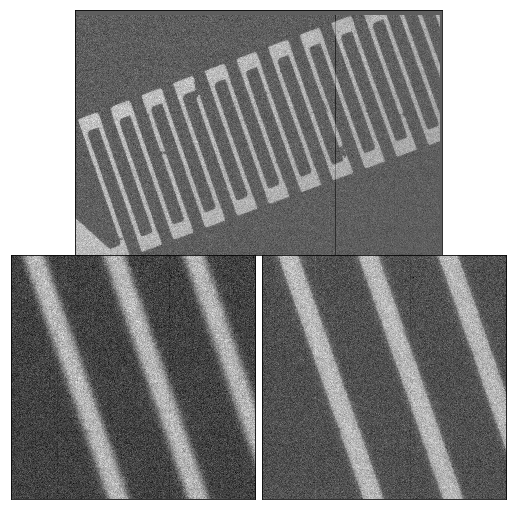

In [671]:
def format_axes(fig):
    for ax in fig.axes:
        ax.tick_params(labelbottom=False, labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
On_crop=im1[1500:2100,100:700]
Off_crop=im2_shifted[1500:2100,100:700]
fig=plt.figure(figsize=(9,9))
grid = plt.GridSpec(2, 4, figure=fig, hspace=0, wspace=0)
Main_im = fig.add_subplot(grid[0, :])
On_im = fig.add_subplot(grid[1,:2] )
Off_im = fig.add_subplot(grid[1:,2:])
Main_im.imshow(im2_shifted, cmap='gray')
On_im.imshow(On_crop, cmap='gray')
Off_im.imshow(Off_crop,cmap='gray')
format_axes(fig)

In [591]:
im1_crop.shape

(2672, 4008)

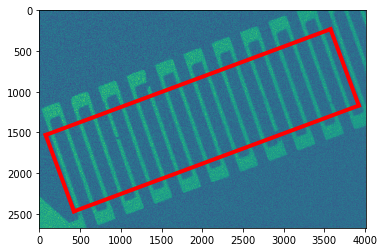

In [587]:
pts=[[250,2000],[3750,700]]
x1=im_linescan(im1, pts, 1000,thresh_type='local',show=True)

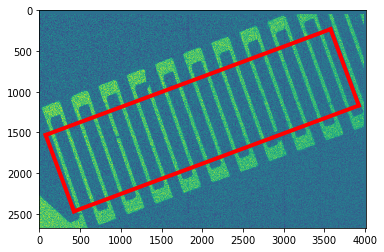

In [586]:
x2=im_linescan(im2_shifted, pts, 1000,thresh_type='local',show=True)

In [611]:
import matplotlib
matplotlib.__version__

'3.0.0'

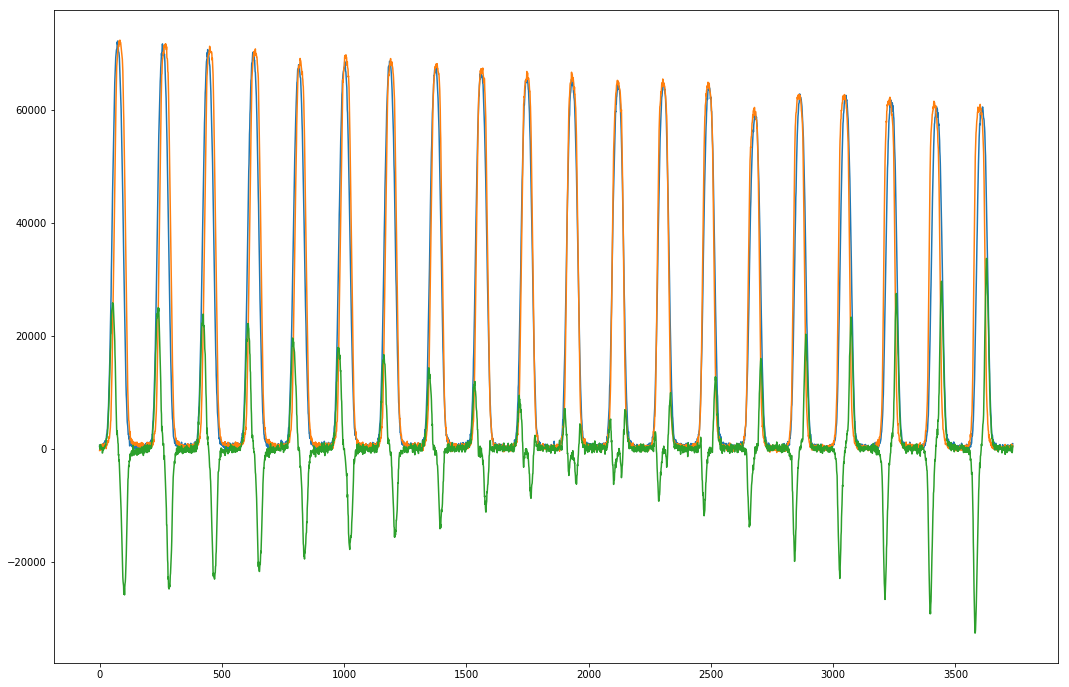

In [588]:
plt.figure(figsize=(18,12))
plt.plot(x1)
plt.plot(x2)
plt.plot(x1-x2)

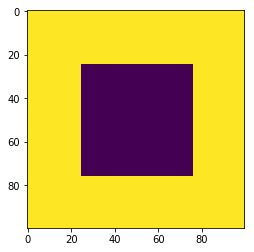

In [451]:
fake_im=np.ones(10000).reshape(100,100)
fake_im[25:76,25:76]=0
plt.imshow(fake_im)

array([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
       21., 21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

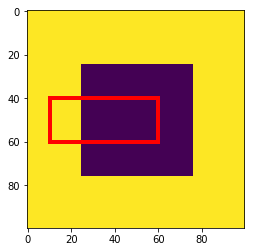

In [452]:
fpts=[[10,50],[60,50]]
im_linescan(fake_im,fpts,20,show=True, show_bin=False)

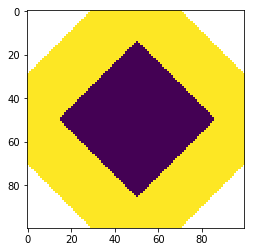

In [303]:
from skimage.transform import rotate
rot_im_fake=rotate(fake_im,45,cval=np.nan, order=0,preserve_range=True)
plt.imshow(rot_im_fake)

array([16., 14., 11., 10.,  9.,  6.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  3.,  5.,  7., 10., 11., 13., 15., 17.])

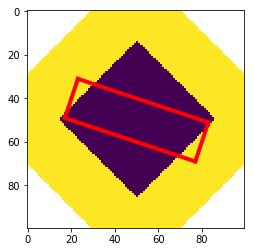

In [457]:
fpts=[[20,40],[80,60]]
im_linescan(rot_im_fake,fpts,20,show=True)

In [527]:
def find_best_line(im,starting_pts,end_xpt,y_guess, width,y_range=100, resolution=5, show=False, show_bin=False):
    '''Changes the y value to get linscans for lots of points to get the slope where the linescan is maximized
       starting_pts is input as [x1,y1]
       resolution is the step size for the search
    '''
    linscan_ls=[]
    y_low=int(y_guess-(y_range/2))
    y_high= int(y_guess+(y_range/2))
    for r in np.arange(y_low,y_high,resolution):
        pts=[starting_pts,[end_xpt,r]]
#         print(pts, im.shape)
        linscan=im_linescan(im,pts,width)
        linscan_ls.append(linscan)
      
    m=[np.max(x) for x in linscan_ls]
    correct_y_ind=np.argmax(m)
    if show ==True:
        x1,y1=starting_pts
        x2=end_xpt
        y2=np.arange(y_low,y_high,resolution)[correct_y_ind]
        pts=np.asarray(get_line_width_coords([[x1,y1],[x2,y2]],width))
        draw_box(im,pts, binary=show_bin)
    return np.array(linscan_ls[correct_y_ind]), np.arange(y_low,y_high,resolution)[correct_y_ind]

# plt.figure(figsize=(18,12))
# plt.plot(linscan)
# plt.plot(np.gradient(linscan))

(array([11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 10., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11.]), 75)

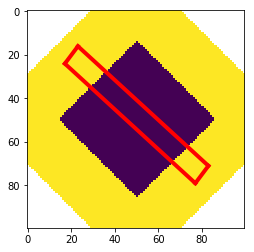

In [530]:
find_best_line(rot_im_fake,[20,20],80,80,10,y_range=10,resolution=1,show=True)

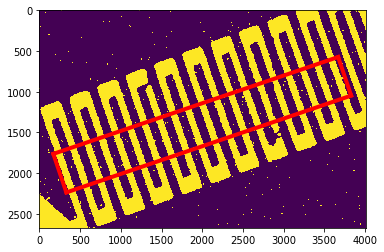

In [534]:
a,b=find_best_line(im1,[250,2000],3750,850,500,y_range=200,resolution=10, show=True, show_bin=True)

In [535]:
b

810

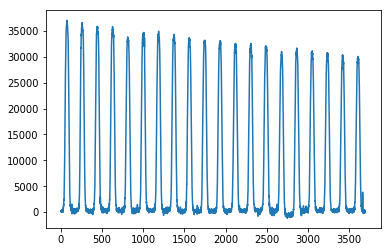

In [692]:
plt.plot(a)